<img src='./img/DataStore_EUMETSAT.png'/>

Copyright (c) 2025 EUMETSAT <br>
License: MIT

<hr>

<a href="./index.ipynb">← Index</a>
<br>
<a href="./1_6_MTG_LI_data_access.ipynb">← Accessing MTG LI products</a><span style="float:right;"><a href="./2_1_Customising_products.ipynb">Using the EUMETSAT Data Tailor with EUMDAC →</a>

# Creating CSV exports for all the collections

This notebook demonstrates how to access and process data from the Meteosat Third Generation (MTG) Lightning Imager (LI) collections. It includes steps for:
- Authenticating with the EUMETSAT Data Store.
- Selecting products from six MTG LI collections.
- Downloading, extracting, and processing NetCDF files.
- Converting data into CSV format for easier analysis.

<div class="alert alert-block alert-info">
<b>LIABILITY CLAUSE:</b><br />
EUMETSAT offers no warranty in respect of the accuracy, completeness, properties, quality, or fitness for use or purpose of any of the EUMETSAT Data and Products or Services provided. EUMETSAT shall not be held liable for (i) any damage derived from the use of EUMETSAT Data and Products or Services; or (ii) any adaptations to any other equipment or software used by users.
</div>

### Collections that will be used


| Product Description  | Data Store collection ID| Data Store |
|:--------------------:|:-----------------------:|:-----------------:|
| LI Accumulated Flashes - MTG - 0 degree | EO:EUM:DAT:0686 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0686) |
| LI Accumulated Flash Area - MTG - 0 degree | EO:EUM:DAT:0687 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0687) |
| LI Accumulated Flash Radiance - MTG - 0 degree | EO:EUM:DAT:0688 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0688) |
| LI Lightning Events Filtered - MTG - 0 degree | EO:EUM:DAT:0690 | [link](https://data.eumetsat.int/data/map/EO:EUM:DAT:0690)
| LI Lightning Flashes - MTG - 0 degree | EO:EUM:DAT:0691 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0691) |
| LI Lightning Groups - MTG - 0 degree | EO:EUM:DAT:0782 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0782) |


### Learning outcomes

At the end of this notebook you will know;
* How to refine your **searches** for MTG LI products in the EUMETSAT Data Store using the `eumdac` API client
* How to **download** products from your refined search results
* How to **convert** products into CSV format
* How to **convert product's epoch time** into datetime
* How MTG LI data is **structured and organised**

### Importing modules and authenticating

As usual, we begin by importing our required modules.

In [1]:
import eumdac
import datetime
import shutil
import os
import glob
import zipfile
import pandas as pd
import netCDF4
import numpy as np
import math

The following utility functions are integral to processing MTG LI data, ensuring accurate geolocation and timestamp representation. They are reused throughout the notebook to handle geostationary coordinates and epoch time conversions.

**epoch_to_datetime** function converts epoch times (and optional offsets) into human-readable datetime strings. The `flash_time` is measured as [epoch time](https://en.wikipedia.org/wiki/Epoch_%28computing%29) in products from Meteosat Third Generation (MTG) satellites. To make it easier to work with them, we will recalculate the regular date time from it. 

**calculate_lat_lon** function calculates geodetic latitude and longitude in degrees from geostationary satellite x and y coordinates (in radians). Returns NaN for invalid or out-of-range coordinates.

**safe_vectorized_calculate_lat_lon** vectorized implementation of calculate_lat_lon function that handles arrays of coordinates while managing potential errors

**save_to_csv** function is used for aligned process of saving the data in csv format.

In [2]:
def epoch_to_datetime(epoch_times, offsets=None):
    """
    Args:
        epoch_times: List or array of epoch times.
        offsets: Optional list or array of time offsets to add to epoch times.

    Returns:
        A list of formatted datetime strings.
    """
    reference = datetime.datetime(2000, 1, 1)  # Reference time for MTG data.
    if offsets is not None:
        epoch_times = epoch_times + offsets
    return [
        (reference + datetime.timedelta(seconds=float(time))).strftime('%Y-%m-%d %H:%M:%S')
        for time in epoch_times
    ]

def calculate_lat_lon(x, y):
    import warnings
    import numpy as np

    h = 42164.537
    r_eq = 6378.137
    r_p = 6356.752314

    """
    Calculate geodetic latitude and longitude in degrees from geostationary x, y coordinates.

    Args:
        x: Geostationary x-coordinate (radians).
        y: Geostationary y-coordinate (radians).

    Returns:
        Tuple (latitude, longitude) in degrees, or NaN if invalid.
    """
    try:
        s_4 = pow(r_eq, 2) / pow(r_p, 2)
        s_5 = pow(h, 2) - pow(r_eq, 2)

        # Suppress "invalid value encountered in sqrt" warnings
        with np.errstate(invalid='ignore'):
            s_d = np.sqrt(
                (h * np.cos(x) * np.cos(y))**2 - 
                (np.cos(y) ** 2 + s_4 * np.sin(y) ** 2) * s_5
            )

        sn = (h * np.cos(x) * np.cos(y) - s_d) / \
             (np.cos(y) ** 2 + s_4 * np.sin(y) ** 2)
        s1 = h - sn * np.cos(x) * np.cos(y)
        s2 = -sn * np.sin(x) * np.cos(y)
        s3 = sn * np.sin(y)
        lat = np.degrees(np.arctan(s_4 * s3 / np.sqrt(s1 ** 2 + s2 ** 2)))
        lon = np.degrees(np.arctan(s2 / s1))
        return lat, lon
    except ValueError:
        return np.nan, np.nan


def safe_vectorized_calculate_lat_lon(x, y):
    lat_lon = np.vectorize(calculate_lat_lon)
    try:
        return lat_lon(x, y)
    except Exception as e:
        print(f"Error in lat/lon calculation: {e}")
        return np.full(x.shape, np.nan), np.full(y.shape, np.nan)

def save_to_csv(dataframe, product_dir, product_name, suffix, units=None):
    """
    Save a dataframe to a CSV file with a standardized naming convention.
    Optionally append units to relevant columns.

    Args:
        dataframe: The pandas DataFrame to save.
        product_dir: Directory where the product was extracted.
        product_name: Name of the product for identification.
        suffix: Additional suffix to add to the file name (e.g., '_data', '_metadata').
        units: Dictionary mapping col_name -> unit string (e.g. {'radiance': 'sr^-1', ...}).
    """
    # If units are supplied, rename columns to add (unit) in the column header
    if units:
        df_copy = dataframe.copy()
        for col, unit in units.items():
            if col in df_copy.columns:
                new_col_name = f"{col} ({unit})"
                df_copy.rename(columns={col: new_col_name}, inplace=True)
        output_csv = os.path.join(product_dir, f"{product_name}{suffix}.csv")
        df_copy.to_csv(output_csv, index=False)
    else:
        output_csv = os.path.join(product_dir, f"{product_name}{suffix}.csv")
        dataframe.to_csv(output_csv, index=False)

    print(f"Data saved successfully to {output_csv}")


Let's authorize with our personal credentials to generate the token.
You consumer key and consumer secret can be retrieved from the API key management page: https://api.eumetsat.int/api-key/

In [3]:
# Insert your personal key and secret into the single quotes
consumer_key = 'YOUR_CONSUMER_KEY'
consumer_secret = 'YOUR_CONSUMER_SECRET'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

This token '69398836-961b-3f91-841e-e02fc1996b80' expires 2025-01-29 17:31:16.447371


## Collections
- [1. EO:EUM:DAT:0691 - LI Lightning Flashes - MTG - 0 degree - LFL](#section1)
- [2. EO:EUM:DAT:0782 - LI Lightning Groups - MTG - 0 degree - LGR](#section2)
- [3. EO:EUM:DAT:0690 - LI Lightning Events Filtered - MTG - 0 degree - LEF](#section3)
- [4. EO:EUM:DAT:0686 - LI Accumulated Flashes - MTG - 0 degree - AF](#section4)
- [5. EO:EUM:DAT:0687 - LI Accumulated Flash Area - MTG - 0 degree - AFA](#section5)
- [6. EO:EUM:DAT:0688 - LI Accumulated Flash Radiance - MTG - 0 degree - AFR](#section6)


## <a id="section1"></a> 1. EO:EUM:DAT:0691 - LI Lightning Flashes - MTG - 0 degree - LFL


Select the EO:EUM:DAT:0691 - LI Lightning Flashes - MTG - 0 degree collection.

In [4]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0691')
print(f"Selected Collection: {selected_collection} - {selected_collection.title}")

Selected Collection: EO:EUM:DAT:0691 - LI Lightning Flashes - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [5]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--x-x--ARC-x_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [6]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--x-x--ARC-x_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we need to uncompress the actual product content. This can be done easily with the following code:

In [7]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--x-x--ARC-x_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [8]:
# For Unix/Linux/MacOS users
!cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
# !cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--x-x--ARC-x_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000

29/01/2025  14:25    <DIR>          .
29/01/2025  14:25    <DIR>          ..
29/01/2025  14:25             5,481 EOPMetadata.xml
29/01/2025  14:25             2,679 manifest.xml
29/01/2025  14:25    <DIR>          quicklooks
29/01/2025  14:25           204,241 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0001.nc
29/01/2025  14:25            42,692 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0002.nc
29/01/2025  14:25            20,731 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--QCK-IMAGE--ARC-PNG_C_EUMT_20240731000016_L2PF_OPE_2024

As can be seen above, a product is made of the following files:
- **Body chunks (NetCDF)**: One or multiple body chunks (depending on product type) contain the measured data values in NetCDF structure.
- **Trailer chunk (NetCDF)**: One trailer chunk that contains at least the list of preceding body chunks that have been produced for the dataset. 
- **Quicklooks (JPG)**: Images related to data that enable fast viewing for the purpose of selection by archive users.
- **manifest.xml**: The manifest contains further information about the SIP especially the relationships among the different items constituting the package.
- **EOPMetadata.xml**: The EOPMetadata file contains metadata about the product based on the OGC Earth Observation Metadata Profile of Observations and Measurements (OGC document 10-157r4).

You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate  values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [9]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# find the CHK-BODY file for LFL
nc_files = glob.glob(os.path.join(product_dir, "*LFL*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for LFL product!")
    
netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [10]:
for var_name in li_product.variables:
    var = li_product.variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

Variable Name: auxiliary_dataset_identifier , Shape: (1,)
Variable Name: auxiliary_dataset_status , Shape: (1,)
Variable Name: l1b_missing_warning , Shape: ()
Variable Name: l1b_geolocation_warning , Shape: ()
Variable Name: l1b_radiometric_warning , Shape: ()
Variable Name: flash_time , Shape: (6678,)
Variable Name: latitude , Shape: (6678,)
Variable Name: longitude , Shape: (6678,)
Variable Name: radiance , Shape: (6678,)
Variable Name: flash_id , Shape: (6678,)
Variable Name: number_of_groups , Shape: (6678,)
Variable Name: number_of_events , Shape: (6678,)
Variable Name: flash_duration , Shape: (6678,)
Variable Name: flash_footprint , Shape: (6678,)
Variable Name: truncated_flashes , Shape: (0,)
Variable Name: flash_filter_confidence , Shape: (6678,)


Now, we can choose the variables we want to have in our CSV:

In [11]:
latitude = li_product['latitude'][:]
longitude = li_product['longitude'][:]
flash_id = li_product['flash_id'][:]
flash_time = li_product['flash_time'][:]
flash_duration = li_product['flash_duration'][:]
flash_footprint = li_product['flash_footprint'][:]
radiance = li_product['radiance'][:]
number_of_events = li_product['number_of_events'][:]
number_of_groups = li_product['number_of_groups'][:]
flash_filter_confidence = li_product['flash_filter_confidence'][:]


To bring them into a CSV structure, we are creating a dataframe where each observation is a row and every variable/value is in a separate column.

In [12]:
# Convert the epoch_time to human-readable UTC
flash_time_UTC = epoch_to_datetime(flash_time)

lfl_li_df = pd.DataFrame({
    'latitude': np.round(latitude.flatten(), 3),
    'longitude': np.round(longitude.flatten(), 3),
    'flash_id': flash_id.flatten(),
    'flash_time': flash_time,        # raw epoch
    'flash_time_UTC': flash_time_UTC,# newly added
    'flash_duration(ms)': flash_duration.flatten(),
    'flash_footprint(km2)': flash_footprint.flatten(),
    'radiance(scaled)': radiance.flatten(),
    'number_of_events': number_of_events.flatten(),
    'number_of_groups': number_of_groups.flatten(),
    'flash_filter_confidence(not_scaled)': flash_filter_confidence.flatten(),
})

Our dataframe is now generated:

In [13]:
lfl_li_df

,latitude,longitude,flash_id,flash_time,flash_time_UTC,flash_duration(ms),flash_footprint(km2),radiance(scaled),number_of_events,number_of_groups,flash_filter_confidence(not_scaled)
0,-1.256,-70.350998,1966311,7.756986e+08,2024-07-30 23:50:06,127,5,43.0,20,6,NaN
1,-2.808,-64.461998,1966314,7.756986e+08,2024-07-30 23:50:07,394,12,74.0,24,6,NaN
2,-2.722,-64.281998,1966321,7.756986e+08,2024-07-30 23:50:08,4,10,33.0,17,3,NaN
3,-1.501,-64.749001,1966322,7.756986e+08,2024-07-30 23:50:08,544,31,1098.0,173,20,NaN
4,-2.724,-64.267998,1966324,7.756986e+08,2024-07-30 23:50:08,126,14,71.0,34,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6673,12.736,44.009998,1985839,7.756992e+08,2024-07-31 00:00:04,1,9,23.0,9,1,NaN
6674,6.372,8.459000,1985842,7.756992e+08,2024-07-31 00:00:05,497,25,2508.0,447,136,NaN
6675,12.436,44.534000,1985845,7.756992e+08,2024-07-31 00:00:05,99,10,66.0,28,4,NaN
6676,17.812,19.587999,1985846,7.756992e+08,2024-07-31 00:00:05,590,25,599.0,184,16,NaN


Finally, you can save the table in a csv file.

In [14]:
# Save CSV with optional units
save_to_csv(
    lfl_li_df, 
    product_dir, 
    "LI_LFL", 
    "_data",
    units={
        "latitude": "deg",
        "longitude": "deg",
        "flash_time": "seconds since 2000-01-01",
        "flash_time_UTC": "UTC",
        "flash_duration(ms)": "ms",
        "flash_footprint(km2)": "km2",
        "radiance(scaled)": "scaled radiance",
    }
)

Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--x-x--ARC-x_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000\LI_LFL_data.csv


## <a id="section2"></a> 2. EO:EUM:DAT:0782 - LI Lightning Groups - MTG - 0 degree - LGR

Select the EO:EUM:DAT:0782 - LI Lightning Groups - MTG - 0 degree - LGR collection.

In [15]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0782')
print(f"Selected Collection: {selected_collection} - {selected_collection.title}")

Selected Collection: EO:EUM:DAT:0782 - LI Lightning Groups - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [16]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--x-x--ARC-x_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [17]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--x-x--ARC-x_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we have to uncompress the actual product content. This can simply be done with the following code:

In [18]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--x-x--ARC-x_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [19]:
# For Unix/Linux/MacOS users
!cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
# !cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--x-x--ARC-x_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000

29/01/2025  14:25    <DIR>          .
29/01/2025  14:25    <DIR>          ..
29/01/2025  14:25             5,482 EOPMetadata.xml
29/01/2025  14:25             2,680 manifest.xml
29/01/2025  14:25    <DIR>          quicklooks
29/01/2025  14:25         3,275,672 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240731000014_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0001.nc
29/01/2025  14:25            14,293 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0002.nc
29/01/2025  14:25            20,650 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--QCK-IMAGE--ARC-PNG_C_EUMT_20240731000014_L2PF_OPE_2024

You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate  values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [20]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# find the CHK-BODY file for LGR
nc_files = glob.glob(os.path.join(product_dir, "*LGR*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for LGR product!")

netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [21]:
for var_name in li_product.variables:
    var = li_product.variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

Variable Name: auxiliary_dataset_identifier , Shape: (1,)
Variable Name: auxiliary_dataset_status , Shape: (1,)
Variable Name: l1b_missing_warning , Shape: ()
Variable Name: l1b_geolocation_warning , Shape: ()
Variable Name: l1b_radiometric_warning , Shape: ()
Variable Name: group_time , Shape: (126326,)
Variable Name: latitude , Shape: (126326,)
Variable Name: longitude , Shape: (126326,)
Variable Name: radiance , Shape: (126326,)
Variable Name: group_id , Shape: (126326,)
Variable Name: flash_id , Shape: (126326,)
Variable Name: number_of_events , Shape: (126326,)
Variable Name: group_filter_qa , Shape: (126326,)


Now, we can choose the variables we want to have in our CSV:

In [22]:
latitude = li_product['latitude'][:]
longitude = li_product['longitude'][:]
flash_id = li_product['flash_id'][:]
group_id = li_product['group_id'][:]
radiance = li_product['radiance'][:]
number_of_events = li_product['number_of_events'][:]
group_time = li_product['group_time'][:]
group_filter_qa = li_product['group_filter_qa'][:]


To bring them into a CSV structure, we are creating a dataframe where each observation is a row and every variable/value is in a separate column.

In [23]:
# Convert group_time from epoch to UTC
group_time_UTC = epoch_to_datetime(group_time)

lgr_li_df = pd.DataFrame({
    'latitude': np.round(latitude.flatten(), 3),
    'longitude': np.round(longitude.flatten(), 3),
    'flash_id': flash_id.flatten(),
    'group_id': group_id.flatten(),
    'group_time': group_time,       # raw epoch
    'group_time_UTC': group_time_UTC,  # newly added
    'radiance(scaled)': radiance.flatten(),
    'number_of_events': number_of_events.flatten(),
    'group_filter_qa': group_filter_qa.flatten(),
})

Our dataframe is now generated:

In [24]:
lgr_li_df

,latitude,longitude,flash_id,group_id,group_time,group_time_UTC,radiance(scaled),number_of_events,group_filter_qa
0,-1.239000,-70.411003,1966311,11045605,7.756986e+08,2024-07-30 23:50:06,7.0,3,NaN
1,-1.256000,-70.366997,1966311,11045606,7.756986e+08,2024-07-30 23:50:06,9.0,5,NaN
2,-1.239000,-70.334999,1966311,11045607,7.756986e+08,2024-07-30 23:50:06,2.5,1,NaN
3,-1.266000,-70.293999,1966311,11045608,7.756986e+08,2024-07-30 23:50:06,6.0,3,NaN
4,-1.266000,-70.293999,1966311,11045609,7.756986e+08,2024-07-30 23:50:06,6.0,3,NaN
...,...,...,...,...,...,...,...,...,...
126321,17.801001,19.583000,1985846,11185695,7.756992e+08,2024-07-31 00:00:06,18.5,9,NaN
126322,17.806999,19.599001,1985846,11185696,7.756992e+08,2024-07-31 00:00:06,6.5,4,NaN
126323,12.998000,44.091000,1985847,11185697,7.756992e+08,2024-07-31 00:00:05,2.0,1,NaN
126324,12.998000,44.091000,1985847,11185698,7.756992e+08,2024-07-31 00:00:05,2.5,1,NaN


Finally, you can save the table in a csv file.

In [25]:
save_to_csv(
    lgr_li_df, 
    product_dir, 
    "LI_LGR", 
    "_data",
    units={
        "latitude": "deg",
        "longitude": "deg",
        "group_time": "seconds since 2000-01-01",
        "group_time_UTC": "UTC",
        "radiance(scaled)": "scaled radiance",
    }
)

Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LGR--FD--x-x--ARC-x_C_EUMT_20240731000016_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000\LI_LGR_data.csv


## <a id="section3"></a> 3. EO:EUM:DAT:0690 - LI Lightning Events Filtered - MTG - 0 degree - LEF

Select the EO:EUM:DAT:0690 - LI Lightning Events Filtered - MTG - 0 degree collection.

In [26]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection("EO:EUM:DAT:0690")
print(f"Selected Collection: {selected_collection} - {selected_collection.title}")

Selected Collection: EO:EUM:DAT:0690 - LI Lightning Events Filtered - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [27]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [28]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we have to uncompress the actual product content. This can simply be done with the following code:

In [29]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [30]:
# For Unix/Linux/MacOS users
!cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
# !cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000

29/01/2025  14:25    <DIR>          .
29/01/2025  14:25    <DIR>          ..
29/01/2025  14:25             5,474 EOPMetadata.xml
29/01/2025  14:25             2,663 manifest.xml
29/01/2025  14:25    <DIR>          quicklooks
29/01/2025  14:25        21,156,222 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--CHK-BODY---NC4E_C_EUMT_20240731000018_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0001.nc
29/01/2025  14:25            14,293 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--CHK-TRAIL---NC4E_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0002.nc
29/01/2025  14:25            26,366 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--QCK-IMAGE---PNG_C_EUMT_20240731000018_L2PF_OPE_20240730235007_2

You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate  values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [31]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# find the CHK-BODY file for LEF
nc_files = glob.glob(os.path.join(product_dir, "*LEF*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for LEF product!")

netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [32]:
for var_name in li_product.groups['data'].groups['east'].variables:
    var = li_product.groups['data'].groups['east'].variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

yaw_flip_summer = li_product.groups['data'].variables['yaw_flip_summer'][:]

Variable Name: detector , Shape: ()
Variable Name: epoch_time , Shape: ()
Variable Name: time_offset , Shape: (412196,)
Variable Name: event_id , Shape: (412196,)
Variable Name: detector_row , Shape: (412196,)
Variable Name: detector_column , Shape: (412196,)
Variable Name: latitude , Shape: (412196,)
Variable Name: longitude , Shape: (412196,)
Variable Name: radiance , Shape: (412196,)
Variable Name: group_id , Shape: (412196,)
Variable Name: flash_id , Shape: (412196,)
Variable Name: event_filter_qa , Shape: (412196,)


The Lightning Imager data is processed separately for each direction (east, west, and north). This ensures efficient handling of geolocation and measurement variables specific to each segment of the satellite’s field of view. The script dynamically checks for the presence of data in each direction and skips missing ones. After extracting relevant variables, we enrich the data with calculated timestamps and metadata, preparing it for further analysis and visualization.

We select key variables from the dataset to include in our CSV output, such as geolocation (latitude, longitude), event details (flash_id, event_id), radiance, and quality assurance metrics. For each direction (east, west, north), we organize the variables into a structured pandas DataFrame, where each row corresponds to an observation and each column represents a specific variable.

In [33]:
directions = ['west', 'east', 'north']

variables = [
    'latitude',
    'longitude',
    'event_filter_qa',
    'flash_id',
    'group_id',
    'radiance',
    'time_offset',
    'event_id',
    'detector_row',
    'detector_column',
    'epoch_time',
    'detector'
]



These DataFrames are then exported as separate CSV files (east_data.csv, west_data.csv, north_data.csv), allowing for focused analysis or visualization of specific directional data. This approach ensures a clear and concise representation of the Lightning Imager data.

In [34]:
# Create DataFrames for each direction
dataframes = {}

for direction in directions:
    try:
        # skip if direction is missing
        if direction not in li_product.groups["data"].groups:
            print(f"Direction {direction} not found in NetCDF file. Skipping.")
            continue

        # extract variables
        group = li_product.groups["data"].groups[direction]
        data = {var: group.variables[var][:] for var in variables if var in group.variables}

        # add calculated time and attributes
        data["time_UTC"] = epoch_to_datetime(data.get("epoch_time", []), data.get("time_offset", []))
        data["detector"] = getattr(group, "detector", "Unknown")
        data["yaw_flip_summer"] = getattr(li_product.groups["data"], "yaw_flip_summer", "Unknown")

        # create DataFrame
        dataframes[direction] = pd.DataFrame({
            f"{direction}_latitude": np.round(data["latitude"].flatten(), 3),
            f"{direction}_longitude": np.round(data["longitude"].flatten(), 3),
            f"{direction}_flash_id": data["flash_id"].flatten(),
            f"{direction}_group_id": data["group_id"].flatten(),
            f"{direction}_radiance(scaled)": data["radiance"].flatten(),
            f"{direction}_event_filter_qa": data["event_filter_qa"].flatten(),
            f"{direction}_event_id": data["event_id"].flatten(),
            f"{direction}_detector_row": data["detector_row"].flatten(),
            f"{direction}_detector_column": data["detector_column"].flatten(),
            f"{direction}_time": data["time_UTC"],
            f"{direction}_detector": [data["detector"]] * len(data["latitude"]),
            "yaw_flip_summer": [data["yaw_flip_summer"]] * len(data["latitude"])
        })

        print(f"DataFrame for {direction} created successfully.")
    except Exception as e:
        print(f"Error processing {direction}: {e}")


for direction, df in dataframes.items():
    df.to_csv(f"{direction}_data.csv", index=False)
    print(f"Saved {direction} DataFrame to {direction}_data.csv")



DataFrame for west created successfully.


DataFrame for east created successfully.
DataFrame for north created successfully.
Saved west DataFrame to west_data.csv
Saved east DataFrame to east_data.csv
Saved north DataFrame to north_data.csv


Our dataframe is now generated:

In [35]:
east_df = dataframes["east"]
print(east_df)


        east_latitude  east_longitude  east_flash_id  east_group_id  \
0           13.187000       44.044998        1966440       11046484   
1           13.187000       44.044998        1966440       11046485   
2           13.157000       44.085999        1966440       11046485   
3           13.152000       43.986000        1966440       11046485   
4           13.122000       44.026001        1966440       11046485   
...               ...             ...            ...            ...   
412191      17.743999       19.624001        1985846       11185695   
412192      17.839001       19.605000        1985846       11185696   
412193      17.806999       19.566999        1985846       11185696   
412194      17.809000       19.632000        1985846       11185696   
412195      17.777000       19.594000        1985846       11185696   

        east_radiance(scaled)  east_event_filter_qa  east_event_id  \
0                         2.6                   0.0       54211466   
1      

Finally, you can save the table in a csv file.

In [36]:
for direction, df in dataframes.items():
    save_to_csv(
        df, 
        product_dir, 
        f"LI_LEF_{direction}", 
        "_data",
        units={
            f"{direction}_latitude": "deg",
            f"{direction}_longitude": "deg",
            f"{direction}_time": "UTC",
            f"{direction}_radiance(scaled)": "scaled radiance"
        }
    )

Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000\LI_LEF_west_data.csv
Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000\LI_LEF_east_data.csv
Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LEF--FD--x-x---x_C_EUMT_20240731000020_L2PF_OPE_20240730235007_20240731000007_N__T_0144_0000\LI_LEF_north_data.csv


## <a id="section4"></a> 4. EO:EUM:DAT:0686 - LI Accumulated Flashes - MTG - 0 degree - AF

Select the EO:EUM:DAT:0686 - LI Accumulated Flashes - MTG - 0 degree - AF collection.

In [37]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0686')
print(f"{selected_collection} - {selected_collection.title}")

EO:EUM:DAT:0686 - LI Accumulated Flashes - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [38]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [39]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we have to uncompress the actual product content. This can simply be done with the following code:

In [40]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [41]:
# For Unix/Linux/MacOS users
!cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
# !cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000

29/01/2025  14:25    <DIR>          .
29/01/2025  14:25    <DIR>          ..
29/01/2025  14:25             5,476 EOPMetadata.xml
29/01/2025  14:25             1,993 manifest.xml
29/01/2025  14:25         2,392,741 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0001.nc
29/01/2025  14:25            14,297 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0002.nc
               4 File(s)      2,414,507 bytes
               2 Dir(s)  21,474,074,624 bytes free


You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [42]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# find the CHK-BODY file for AF
nc_files = glob.glob(os.path.join(product_dir, "*AF--FD*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for AF product!")

netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [43]:
for var_name in li_product.variables:
    var = li_product.variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

Variable Name: auxiliary_dataset_identifier , Shape: (1,)
Variable Name: auxiliary_dataset_status , Shape: (1,)
Variable Name: mtg_geos_projection , Shape: ()
Variable Name: accumulation_start_times , Shape: (20,)
Variable Name: accumulation_offsets , Shape: (20,)
Variable Name: x , Shape: (350928,)
Variable Name: y , Shape: (350928,)
Variable Name: flash_accumulation , Shape: (350928,)
Variable Name: l1b_missing_warning , Shape: (20,)
Variable Name: l1b_geolocation_warning , Shape: (20,)
Variable Name: l1b_radiometric_warning , Shape: (20,)
Variable Name: average_flash_qa , Shape: (20,)


Now, we can choose the variables we want to have in our CSV:

In [44]:
x = li_product['x'][:]
y = li_product['y'][:]
flash_accumulation = li_product['flash_accumulation'][:]

In [45]:
accumulation_start_times = li_product['accumulation_start_times'][:]
accumulation_offsets = li_product['accumulation_offsets'][:]
l1b_missing_warning = li_product['l1b_missing_warning'][:]
l1b_geolocation_warning = li_product['l1b_geolocation_warning'][:]
l1b_radiometric_warning = li_product['l1b_radiometric_warning'][:]
average_flash_qa = li_product['average_flash_qa'][:]

To bring them into a CSV structure, we are creating a dataframe where each observation is a row and every variable/value is in a separate column.

In [46]:
# extract variables from the NetCDF file
accumulation_start_times = li_product['accumulation_start_times'][:]
accumulation_offsets = li_product['accumulation_offsets'][:]
average_flash_qa = li_product['average_flash_qa'][:]
warnings = {
    "missing_warning": li_product['l1b_missing_warning'][:],
    "geolocation_warning": li_product['l1b_geolocation_warning'][:],
    "radiometric_warning": li_product['l1b_radiometric_warning'][:],
}

# convert lat/lon
latitudes, longitudes = safe_vectorized_calculate_lat_lon(x, y)


# create main flash DataFrame
af_flash_df = pd.DataFrame({
    'x': x,
    'y': y,
    'latitude': latitudes,
    'longitude': longitudes,
    'flash_accumulation': flash_accumulation
}).dropna()  # drop NaN values for valid lat/lon

# create metadata DataFrame
af_metadata_df = pd.DataFrame({
    'accumulation_start_times': accumulation_start_times.flatten(),
    'accumulation_offsets': accumulation_offsets.flatten(),
    'accumulation_time': epoch_to_datetime(accumulation_start_times, accumulation_offsets),
    **warnings,
    'average_flash_qa': average_flash_qa.flatten()
})


Our dataframe is now generated:

In [47]:
af_flash_df

,x,y,latitude,longitude,flash_accumulation
0,0.151314,-0.008299,-3.099461,-77.657127,0.333
1,0.151314,-0.008132,-3.036358,-77.605164,0.200
2,0.151259,-0.008355,-3.117868,-77.360861,0.333
3,0.151259,-0.008299,-3.096855,-77.344578,0.333
4,0.151259,-0.008243,-3.075846,-77.328475,0.333
...,...,...,...,...,...
350923,-0.115547,0.036243,12.556492,44.705186,0.065
350924,-0.115603,0.036019,12.477623,44.714711,0.217
350925,-0.115603,0.036075,12.497562,44.720195,0.217
350926,-0.115603,0.036187,12.537448,44.731198,0.065


Finally, you can save the table in a csv file.

In [48]:
# Save flash data
save_to_csv(
    af_flash_df, 
    product_dir, 
    "LI_AF", 
    "_flash",
    units={
        "latitude": "deg",
        "longitude": "deg",
        "flash_accumulation": "count" 
    }
)

# Save metadata
save_to_csv(
    af_metadata_df, 
    product_dir, 
    "LI_AF", 
    "_metadata",
    units={
        "accumulation_start_times": "seconds since 2000-01-01",
        "accumulation_offsets": "seconds",
        "accumulation_time": "UTC",
        "average_flash_qa": "unitless"
    }
)


Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AF_flash.csv
Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AF--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AF_metadata.csv


## <a id="section5"></a> 5. EO:EUM:DAT:0687 - LI Accumulated Flash Area - MTG - 0 degree - AFA

Select the EO:EUM:DAT:0687 - LI Accumulated Flash Area - MTG - 0 degree - AFA collection.

In [49]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0687')
print(f"{selected_collection} - {selected_collection.title}")

EO:EUM:DAT:0687 - LI Accumulated Flash Area - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [50]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [51]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we have to uncompress the actual product content. This can simply be done with the following code:

In [52]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [53]:
# For Unix/Linux/MacOS users
!cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
# !cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000

29/01/2025  14:26    <DIR>          .
29/01/2025  14:26    <DIR>          ..
29/01/2025  14:26             5,480 EOPMetadata.xml
29/01/2025  14:26             2,681 manifest.xml
29/01/2025  14:26    <DIR>          quicklooks
29/01/2025  14:26         3,179,008 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240731001017_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0001.nc
29/01/2025  14:26            14,293 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0002.nc
29/01/2025  14:26            23,123 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--QCK-IMAGE--ARC-PNG_C_EUMT_20240731001017_L2PF_OPE_2024

You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate  values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [54]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# find the CHK-BODY file for AFA
nc_files = glob.glob(os.path.join(product_dir, "*AFA--FD*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for AFA product!")

netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [55]:
for var_name in li_product.variables:
    var = li_product.variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

Variable Name: auxiliary_dataset_identifier , Shape: (1,)
Variable Name: auxiliary_dataset_status , Shape: (1,)
Variable Name: mtg_geos_projection , Shape: ()
Variable Name: accumulation_start_times , Shape: (20,)
Variable Name: accumulation_offsets , Shape: (20,)
Variable Name: x , Shape: (350928,)
Variable Name: y , Shape: (350928,)
Variable Name: accumulated_flash_area , Shape: (350928,)
Variable Name: l1b_missing_warning , Shape: (20,)
Variable Name: l1b_geolocation_warning , Shape: (20,)
Variable Name: l1b_radiometric_warning , Shape: (20,)
Variable Name: average_flash_qa , Shape: (20,)


Now, we can choose the variables we want to have in our CSV:

In [56]:
x = li_product['x'][:]
y = li_product['y'][:]
flash_area = li_product['accumulated_flash_area'][:]


In [57]:
start_times, offsets = li_product['accumulation_start_times'][:], li_product['accumulation_offsets'][:]


warnings = {
    "missing_warning": li_product['l1b_missing_warning'][:],
    "geolocation_warning": li_product['l1b_geolocation_warning'][:],
    "radiometric_warning": li_product['l1b_radiometric_warning'][:],
}
average_flash_qa = li_product['average_flash_qa'][:]

To bring them into a CSV structure, we are creating a dataframe where each observation is a row and every variable/value is in a separate column.

In [58]:
# calculate latitude and longitude
latitudes, longitudes = safe_vectorized_calculate_lat_lon(x, y)


# create DataFrames
afa_area_df = pd.DataFrame({
    'x': x, 'y': y, 'latitude': latitudes, 'longitude': longitudes, 'accumulated_flash_area': flash_area
}).dropna()

afa_metadata_df = pd.DataFrame({
    'accumulation_start_times': start_times.flatten(),
    'accumulation_offsets': offsets.flatten(),
    'accumulation_time': epoch_to_datetime(start_times, offsets),
    **warnings,
    'average_flash_qa': average_flash_qa.flatten()
})

Our dataframe is now generated:

In [59]:
afa_area_df

print("Max AFA value:", afa_area_df["accumulated_flash_area"].max())




Max AFA value: 14


In [60]:
# save flash area data
save_to_csv(afa_area_df, product_dir, "LI_AFA", "_area")

# save metadata
save_to_csv(afa_metadata_df, product_dir, "LI_AFA", "_metadata")


Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AFA_area.csv
Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AFA_metadata.csv


Finally, you can save the table in a csv file.

## <a id="section6"></a> 6. EO:EUM:DAT:0688 - LI Accumulated Flash Radiance - MTG - 0 degree - AFR

Select the EO:EUM:DAT:0688 - LI Accumulated Flash Radiance - MTG - 0 degree - AFR collection.

In [61]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0688')
print(f"{selected_collection} - {selected_collection.title}")

EO:EUM:DAT:0688 - LI Accumulated Flash Radiance - MTG - 0 degree


### Filtering and downloading products based on time interval


After selecting the collection, search for a product. So, let's run the query to get the IDs for the products that are sensed within a full day and select the latest one.

In [62]:
# Set sensing start and end time
start = datetime.datetime(2024, 7, 30, 0, 0)
end = datetime.datetime(2024, 7, 31, 0, 0)

# Retrieve product(s) that match our filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

print(f"{product}")

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Download products

We have found our relevant products. Now we would like to download only one. We can transfer the prouducts into  our directory.

In [63]:
download_dir = 'downloads/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

def download_product(product, download_dir):
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
    return os.path.join(download_dir, fsrc.name)

file_path = download_product(product, download_dir)
print(f"Product downloaded to: {file_path}")

Product downloaded to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000.zip


We downloaded a single product, based on our search parameters.

### Extract the product SIP file

To further work with the data, we have to uncompress the actual product content. This can simply be done with the following code:

In [64]:
def extract_sip_file(file_path):
    if file_path.endswith('.zip') and os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=file_path[:-4])
        os.remove(file_path)
        return file_path[:-4]
    raise FileNotFoundError(f"File {file_path} not found or not a ZIP file.")

product_dir = extract_sip_file(file_path)
print(f"Product extracted to: {product_dir}")

Product extracted to: downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000


### Structure of products

A product consists of multiple files and is delivered as a [SIP](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP). To avoid too long path on Windows OS, we can explore the contents of the product using either of the following commands, depending on your OS.

In [65]:
# For Unix/Linux/MacOS users
# !cd downloads/{product}/ && ls

# For Windows users, uncomment the following line
!cd downloads/{product}/ && dir

 Volume in drive C is Windows
 Volume Serial Number is FE27-64EF

 Directory of c:\Users\zeizis\eumdac_data_store\downloads\W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000

29/01/2025  14:26    <DIR>          .
29/01/2025  14:26    <DIR>          ..
29/01/2025  14:26             5,480 EOPMetadata.xml
29/01/2025  14:26             1,997 manifest.xml
29/01/2025  14:26         2,395,092 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0001.nc
29/01/2025  14:26            14,293 W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0002.nc
               4 File(s)      2,416,862 bytes
               2 Dir(s)  21,408,210,944 bytes free


You can find more information about the [SIP files](https://user.eumetsat.int/resources/user-guides/formats#ID-Submission-Information-Package-SIP) and [MTG LI product/data structure](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide#ID-Level-2-data-characteristics) in the corresponding user guides.

### Converting values into a CSV file

As the MTG LI products are structured NetCDF files, we can convert them easily to text or a comma-separate  values (CSV) files.

We need to specify the filename of the body chunk for our desired product and then load the NetCDF file:

In [66]:
def load_netcdf(file_path):
    return netCDF4.Dataset(file_path, 'r')

# Automatically find the CHK-BODY file for AFR
nc_files = glob.glob(os.path.join(product_dir, "*AFR--FD*CHK-BODY*.nc"))
if not nc_files:
    raise FileNotFoundError("No CHK-BODY *.nc file found for AFR product!")

netcdf_file = nc_files[0]
li_product = load_netcdf(netcdf_file)

Each product has many variables. To list all existing variables we can print them:

In [67]:
for var_name in li_product.variables:
    var = li_product.variables[var_name]
    print(f"Variable Name: {var_name}", f", Shape: {var.shape}")

Variable Name: auxiliary_dataset_identifier , Shape: (1,)
Variable Name: auxiliary_dataset_status , Shape: (1,)
Variable Name: mtg_geos_projection , Shape: ()
Variable Name: accumulation_start_times , Shape: (20,)
Variable Name: accumulation_offsets , Shape: (20,)
Variable Name: x , Shape: (350928,)
Variable Name: y , Shape: (350928,)
Variable Name: flash_radiance , Shape: (350928,)
Variable Name: l1b_missing_warning , Shape: (20,)
Variable Name: l1b_geolocation_warning , Shape: (20,)
Variable Name: l1b_radiometric_warning , Shape: (20,)
Variable Name: average_flash_qa , Shape: (20,)


We need to convert the x and y values to latitude and longitude.

Now, we can choose the variables we want to have in our CSV:

In [68]:
x = li_product['x'][:]
y = li_product['y'][:]
flash_radiance = li_product['flash_radiance'][:]

In [69]:
start_times, offsets = li_product['accumulation_start_times'][:], li_product['accumulation_offsets'][:]
warnings = {
    "missing_warning": li_product['l1b_missing_warning'][:],
    "geolocation_warning": li_product['l1b_geolocation_warning'][:],
    "radiometric_warning": li_product['l1b_radiometric_warning'][:],
}
average_flash_qa = li_product['average_flash_qa'][:]

To bring them into a CSV structure, we are creating a dataframe where each observation is a row and every variable/value is in a separate column.

In [70]:
# calculate latitude and longitude
latitudes, longitudes = safe_vectorized_calculate_lat_lon(x, y)


# create DataFrames
afr_radiance_df = pd.DataFrame({
    'x': x, 'y': y, 'latitude': latitudes, 'longitude': longitudes, 'flash_radiance': flash_radiance
}).dropna()

afr_metadata_df = pd.DataFrame({
    'accumulation_start_times': start_times.flatten(),
    'accumulation_offsets': offsets.flatten(),
    'accumulation_time': epoch_to_datetime(start_times, offsets),
    **warnings,
    'average_flash_qa': average_flash_qa.flatten()
})

Finally, you can save the table in a csv file.

In [71]:
# save radiance data
save_to_csv(afr_radiance_df, product_dir, "LI_AFR", "_radiance")

# save metadata
save_to_csv(afr_metadata_df, product_dir, "LI_AFR", "_metadata")


Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AFR_radiance.csv
Data saved successfully to downloads/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFR--FD--x-x--ARC-x_C_EUMT_20240731001025_L2PF_OPE_20240731000000_20240731001000_N__T_0001_0000\LI_AFR_metadata.csv


Plot a scatter plot of latitude vs longitude with optional coloring.


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_lat_lon_scatter_coastlines(
    dataframe, 
    title, 
    x_col='longitude', 
    y_col='latitude', 
    color_col=None, 
    color_label=None, 
    log_scale=False, 
    exclude_outliers=True,
    cmap='viridis'
):
    """
    Scatter plot with coastlines using Cartopy.
    Args:
        dataframe: Pandas DataFrame containing data to plot.
        title: Title of the plot.
        x_col: Column name for x-axis values (default: 'longitude').
        y_col: Column name for y-axis values (default: 'latitude').
        color_col: Column name for color-coding the points.
        color_label: Label for colorbar (optional).
        log_scale: Whether to apply log scale to the color data.
        exclude_outliers: Whether to exclude extreme outliers.
        cmap: Colormap to use for scatter plot.
    """
    if color_col and color_col in dataframe.columns:
        data = dataframe[color_col]
        
        # Exclude outliers based on percentiles
        if exclude_outliers:
            lower_bound = data.quantile(0.01)
            upper_bound = data.quantile(0.99)
            dataframe = dataframe[(data >= lower_bound) & (data <= upper_bound)]
        
        # Apply log scale if required
        color_data = np.log1p(dataframe[color_col]) if log_scale else dataframe[color_col]
    else:
        color_data = None

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title)

    scatter = ax.scatter(
        dataframe[x_col],
        dataframe[y_col],
        c=color_data,
        cmap=cmap,
        alpha=0.7,
        transform=ccrs.PlateCarree()
    )
    
    # Add color bar if color_col is provided
    if color_col:
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label(color_label or color_col)

    # Add coastlines and gridlines
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_global()
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    plt.show()


LI Lightning Flashes (LFL)

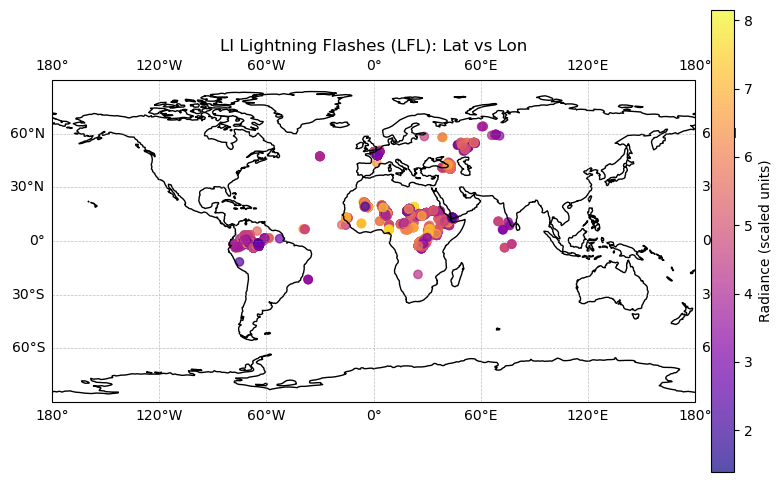

In [73]:
# Plot LI Lightning Flashes (LFL)
plot_lat_lon_scatter_coastlines(
    lfl_li_df, 
    title="LI Lightning Flashes (LFL): Lat vs Lon",
    x_col="longitude",
    y_col="latitude",
    color_col="radiance(scaled)",
    color_label="Radiance (scaled units)",
    log_scale=True,  # log scaling
    exclude_outliers=True,  # filter out outliers
    cmap='plasma'  # plasma colormap
)


LI Lightning Groups (LGR)

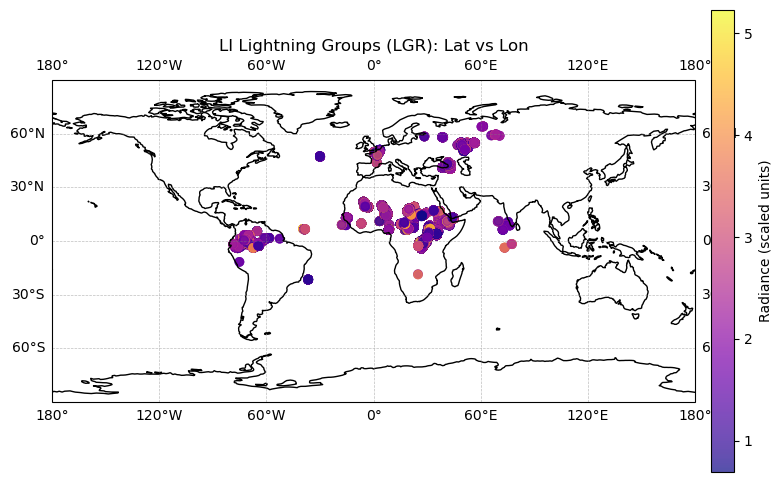

In [74]:
# Plot LI Lightning Groups (LGR)
plot_lat_lon_scatter_coastlines(
    lgr_li_df, 
    title="LI Lightning Groups (LGR): Lat vs Lon",
    x_col="longitude",
    y_col="latitude",
    color_col="radiance(scaled)",
    color_label="Radiance (scaled units)",
    log_scale=True,  # log scaling
    exclude_outliers=True,  # filter out outliers
    cmap='plasma'  # plasma colormap
    )

LI Lightning Events Filtered (LEF)

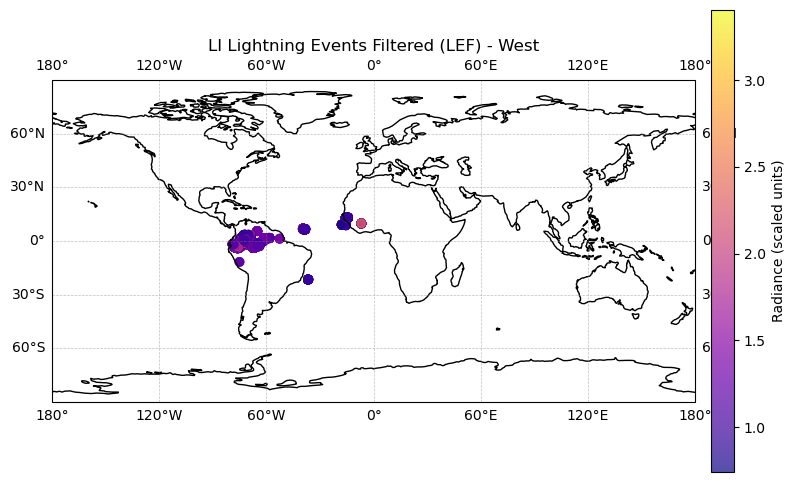

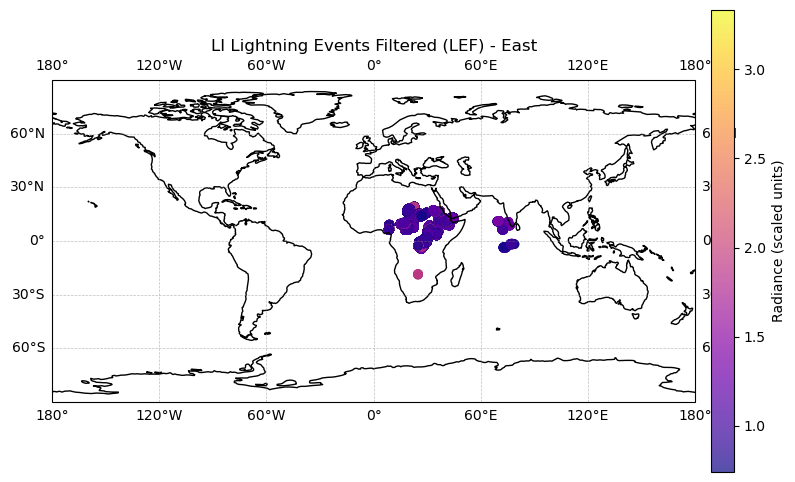

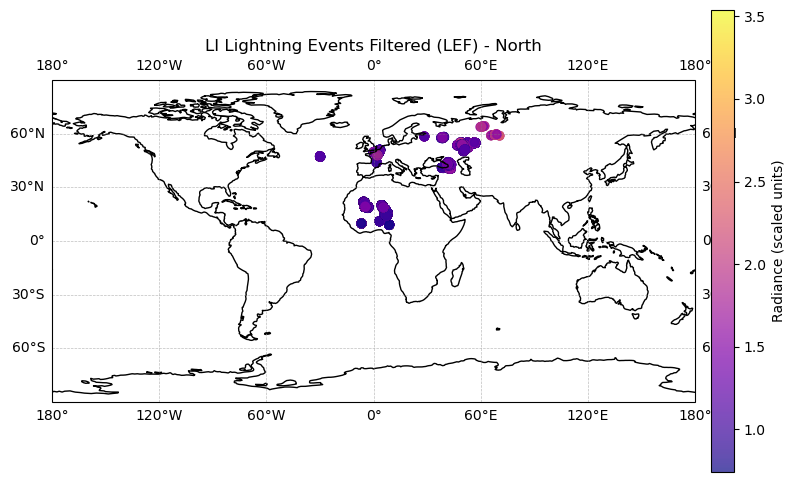

In [75]:
# Plot LI Lightning Events Filtered (LEF) for each direction
for direction, df in dataframes.items():
    try:
        x_col = f"{direction}_longitude"
        y_col = f"{direction}_latitude"
        color_col = f"{direction}_radiance(scaled)"
        plot_lat_lon_scatter_coastlines(
            df,
            title=f"LI Lightning Events Filtered (LEF) - {direction.capitalize()}",
            x_col=x_col,
            y_col=y_col,
            color_col=color_col,
            color_label="Radiance (scaled units)",
            log_scale=True,  # log scaling
            exclude_outliers=True,  # filter out outliers
            cmap='plasma'  # plasma colormap
        )
    except KeyError as e:
        print(f"Column not found for {direction}: {e}")


LI Accumulated Flashes (AF)

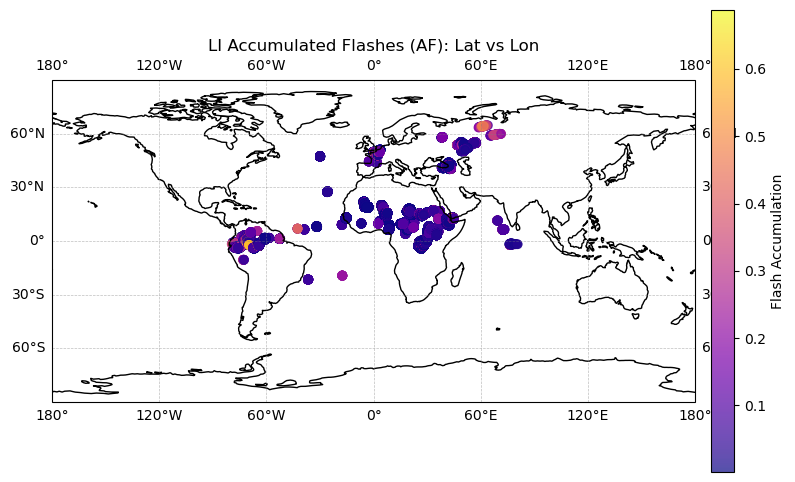

In [76]:
# Plot LI Accumulated Flashes (AF)
plot_lat_lon_scatter_coastlines(
    af_flash_df, 
    title="LI Accumulated Flashes (AF): Lat vs Lon",
    x_col="longitude",
    y_col="latitude",
    color_col="flash_accumulation",
    color_label="Flash Accumulation",
    log_scale=True,  # log scaling
    exclude_outliers=True,  # filter out outliers
    cmap='plasma'  # plasma colormap
)


LI Accumulated Flash Area (AFA)

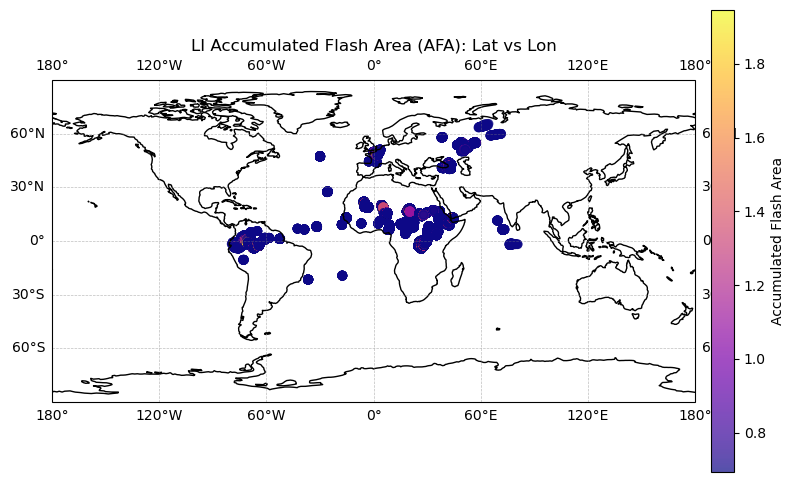

In [77]:
# Plot LI Accumulated Flash Area (AFA)
plot_lat_lon_scatter_coastlines(
    afa_area_df, 
    title="LI Accumulated Flash Area (AFA): Lat vs Lon",
    x_col="longitude",
    y_col="latitude",
    color_col="accumulated_flash_area",
    color_label="Accumulated Flash Area",
    log_scale=True,  # log scaling
    exclude_outliers=True,  # filter out outliers
    cmap='plasma'  # plasma colormap
)


LI Accumulated Flash Radiance (AFR)

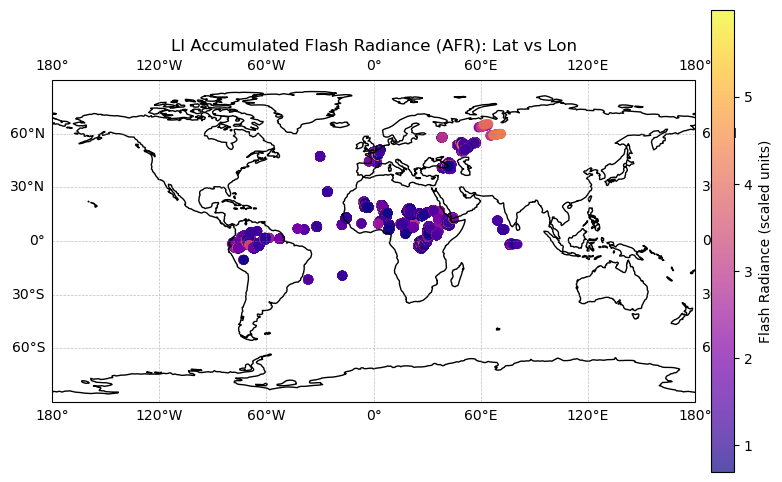

In [78]:
# Plot LI Accumulated Flash Radiance (AFR)
plot_lat_lon_scatter_coastlines(
    afr_radiance_df, 
    title="LI Accumulated Flash Radiance (AFR): Lat vs Lon",
    x_col="longitude",
    y_col="latitude",
    color_col="flash_radiance",
    color_label="Flash Radiance (scaled units)",
    log_scale=True,  # log scaling
    exclude_outliers=True,  # filter out outliers
    cmap='plasma'  # plasma colormap
)


<a href="./index.ipynb">← Index</a>
<br>
<a href="./1_5_MTG_FCI_data_access.ipynb">← Accessing MTG FCI products</a><span style="float:right;"><a href="./2_1_Customising_products.ipynb">Using the EUMETSAT Data Tailor with EUMDAC →</a>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE.TXT">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store">View on GitLab</a> | <a href="https://classroom.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact</a></span></p>